<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/Multi_Step_LSTM_Rainfall_Forecasting_(Next_7_Days).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Step LSTM Rainfall Forecasting (Next 7 Days)

Input shape: (963, 30, 1), Output shape: (963, 7)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,351 (67.78 KB)

 Trainable params: 17,351 (67.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1827 - val_loss: 0.0490
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0301 - val_loss: 0.0231
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0210 - val_loss: 0.0184
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0160 - val_loss: 0.0107
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

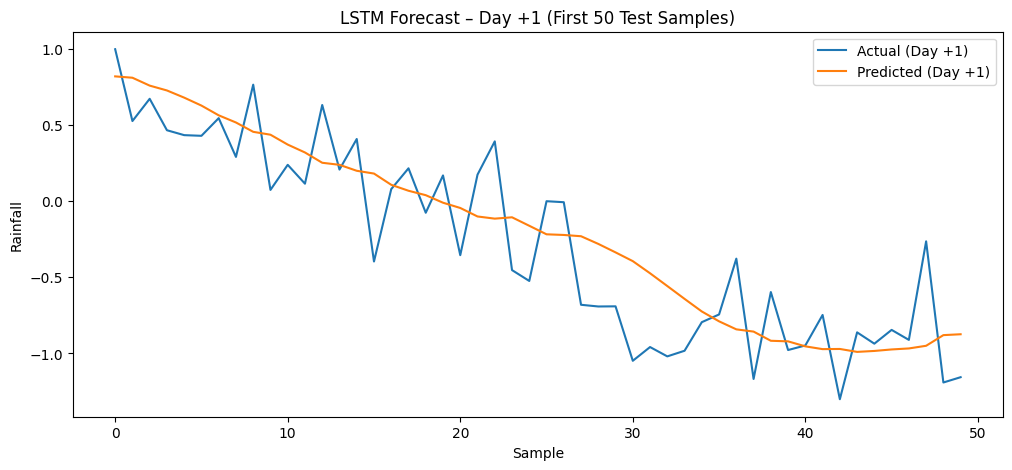

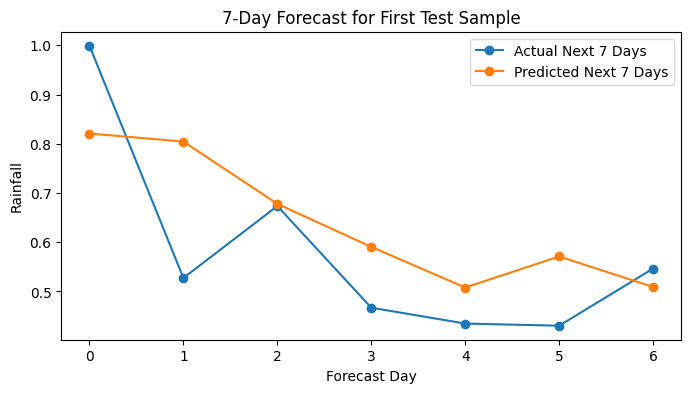

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------
# 1. Generate Synthetic Data
# ---------------------------
np.random.seed(42)
days = 1000
rain = np.sin(np.linspace(0, 50, days)) + 0.3 * np.random.randn(days)
rain = rain.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(rain)

# ---------------------------
# 2. Create Sequences (Sliding Window)
# ---------------------------
window_size = 30  # past 30 days -> predict next 7 days
forecast_horizon = 7

X, y = [], []
for i in range(len(rain_scaled) - window_size - forecast_horizon):
    X.append(rain_scaled[i:i+window_size])
    y.append(rain_scaled[i+window_size:i+window_size+forecast_horizon].flatten())

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")
# X -> (samples, time steps, features)
# y -> (samples, forecast_horizon)

# ---------------------------
# 3. Train/Test Split
# ---------------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 4. Build Multi-Step LSTM Model
# ---------------------------
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(forecast_horizon)  # output 7 values
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# 5. Train Model
# ---------------------------
history = model.fit(X_train, y_train, epochs=25, batch_size=32,
                    validation_split=0.1, verbose=1)

# ---------------------------
# 6. Evaluate Model
# ---------------------------
loss = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss:.4f}")

# ---------------------------
# 7. Make Predictions
# ---------------------------
predictions = model.predict(X_test)
# Rescale back to original units
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# ---------------------------
# 8. Plot Results (First 50 Predictions)
# ---------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled[:50, 0], label="Actual (Day +1)")
plt.plot(predictions_rescaled[:50, 0], label="Predicted (Day +1)")
plt.title("LSTM Forecast – Day +1 (First 50 Test Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall")
plt.legend()
plt.show()

# Plot full multi-step prediction for first test sequence
plt.figure(figsize=(8, 4))
plt.plot(y_test_rescaled[0], 'o-', label="Actual Next 7 Days")
plt.plot(predictions_rescaled[0], 'o-', label="Predicted Next 7 Days")
plt.title("7-Day Forecast for First Test Sample")
plt.xlabel("Forecast Day")
plt.ylabel("Rainfall")
plt.legend()
plt.show()